In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from packaging.version import parse as parse_version
assert parse_version(tf.__version__) < parse_version("2.4.0"), \
    f"Please install TensorFlow version 2.3.1 or older. Your current version is {tf.__version__}."

## Load MNIST dataset

In [2]:
(ds_train, ds_test), ds_info = tfds.load('mnist', 
                              split=['test', 'test'], 
                              shuffle_files=True,
                              as_supervised=True,
                              with_info=True)

#fig = tfds.show_examples(ds_info, ds_train)

def binarize(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.math.round(image/255.)
    return image, tf.cast(image, tf.int32)

ds_train = ds_train.map(binarize)
ds_train = ds_train.cache() # put dataset into memory
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(64)
ds_test = ds_test.map(binarize).batch(64).cache().prefetch(64)

# Create Custom Layers and PixelCNN

In [4]:
class MaskedConv2D(layers.Layer):
    def __init__(self, mask_type, kernel=5, filters=1):
        super(MaskedConv2D, self).__init__()
        self.kernel = kernel
        self.filters = filters
        self.mask_type = mask_type
        
    def build(self, input_shape):

        self.w = self.add_weight(shape=[self.kernel,
                                        self.kernel,
                                        input_shape[-1],
                                        self.filters],
                                initializer='glorot_normal',
                                trainable=True)
        
        self.b = self.add_weight(shape=(self.filters,),
                                initializer='zeros',
                                trainable=True)
        # Create Mask 
        mask = np.ones(self.kernel**2, dtype=np.float32)
        center = len(mask)//2
        mask[center+1:] = 0
        if self.mask_type == 'A':
            mask[center] = 0
            
        mask = mask.reshape((self.kernel, self.kernel, 1, 1))
        
        self.mask = tf.constant(mask, dtype='float32')
        
    def call(self, inputs):
        # mask the convolution
        masked_w = tf.math.multiply(self.w, self.mask)

        # perform conv2d using low level API
        output = tf.nn.conv2d(inputs, masked_w, 1, "SAME") + self.b
        
        return tf.nn.relu(output)
    
class ResidualBlock(layers.Layer):
    def __init__(self, h=32):
        super(ResidualBlock, self).__init__()

        self.forward = Sequential([MaskedConv2D('B', kernel=1, filters=h),
                                   MaskedConv2D('B', kernel=3, filters=h),
                                   MaskedConv2D('B', kernel=1, filters=2*h)])         
    def call(self, inputs):
        x = self.forward(inputs)
        return x + inputs
    
def SimplePixelCnn(hidden_features=64, 
                   output_features=64, 
                   resblocks_num=7):

    inputs  = layers.Input(shape=[28,28,1])
    x = inputs
    
    x = MaskedConv2D('A',kernel=7, filters=2*hidden_features)(x)

    for _ in range(resblocks_num):
        x = ResidualBlock(hidden_features)(x)
        
    x = layers.Conv2D(output_features, (1,1), padding='same', activation='relu')(x)    
    x = layers.Conv2D(1, (1,1), padding='same', activation='sigmoid')(x)
            
    return tf.keras.Model(inputs=inputs, outputs=x, name='PixelCnn')

pixel_cnn = SimplePixelCnn()
pixel_cnn.summary()

Model: "PixelCnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
masked_conv2d (MaskedConv2D) (None, 28, 28, 128)       6400      
_________________________________________________________________
residual_block (ResidualBloc (None, 28, 28, 128)       53504     
_________________________________________________________________
residual_block_1 (ResidualBl (None, 28, 28, 128)       53504     
_________________________________________________________________
residual_block_2 (ResidualBl (None, 28, 28, 128)       53504     
_________________________________________________________________
residual_block_3 (ResidualBl (None, 28, 28, 128)       53504     
_________________________________________________________________
residual_block_4 (ResidualBl (None, 28, 28, 128)       535

# Train

In [7]:
pixel_cnn.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    metrics=[tf.keras.losses.BinaryCrossentropy()])

pixel_cnn.fit(ds_train, epochs = 50, validation_data=ds_test)

Epoch 1/50
157/157 [==============================] - 7s 44ms/step - loss: 0.1447 - binary_crossentropy: 0.1445 - val_loss: 0.1209 - val_binary_crossentropy: 0.1209
Epoch 2/50
157/157 [==============================] - 7s 42ms/step - loss: 0.1027 - binary_crossentropy: 0.1028 - val_loss: 0.1085 - val_binary_crossentropy: 0.1085
Epoch 3/50
157/157 [==============================] - 7s 42ms/step - loss: 0.0978 - binary_crossentropy: 0.0977 - val_loss: 0.0947 - val_binary_crossentropy: 0.0947
Epoch 4/50
157/157 [==============================] - 7s 42ms/step - loss: 0.0945 - binary_crossentropy: 0.0945 - val_loss: 0.0930 - val_binary_crossentropy: 0.0930
Epoch 5/50
157/157 [==============================] - 7s 42ms/step - loss: 0.0922 - binary_crossentropy: 0.0922 - val_loss: 0.0923 - val_binary_crossentropy: 0.0923
Epoch 6/50
157/157 [==============================] - 7s 42ms/step - loss: 0.0906 - binary_crossentropy: 0.0906 - val_loss: 0.0893 - val_binary_crossentropy: 0.0893
Epoch 7/50

# Sample and Display Images

In [9]:
grid_row = 5
grid_col = 5
batch = grid_row * grid_col
h = w = 28
images = np.ones((batch,h,w,1), dtype=np.float32)

for row in range(h):

    for col in range(w):

        prob = pixel_cnn.predict(images)[:,row,col,0]

        pixel_samples = tf.random.categorical(tf.math.log(np.stack([1-prob, prob],1)), 1)

        images[:,row,col,0] = tf.reshape(pixel_samples,[batch])


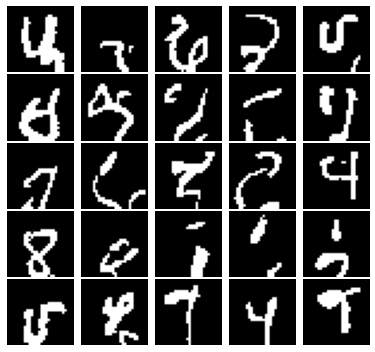

In [10]:
# Display
f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.1,grid_row))

i = 0
for row in range(grid_row):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i,:,:,0], cmap='gray')
        axarr[row,col].axis('off')
        i += 1
f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)        
plt.show()